In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls

drive  sample_data


In [97]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/content/drive/MyDrive/Sem-8/DL/results-ReTrain/geny.pth.tar"
IMAGE_PATH = "/content/drive/MyDrive/Sem-8/DL/X_Monet/photo_jpg"
TEST_IMAGE_PATH = "/content/drive/MyDrive/Sem-8/DL/Test_Images"

In [5]:
DEVICE

'cpu'

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_activation=True, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                padding_mode = "reflect",
                **kwargs
            ) if down 
            else nn.ConvTranspose2d(
                in_channels = in_channels,
                out_channels = out_channels,
                **kwargs),

            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace = True) if use_activation else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride = 1, padding = 1),
            ConvBlock(channels, channels, use_activation=False, kernel_size=3, stride = 1, padding = 1),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    
    def __init__(self, img_channels, num_features = 64, num_residuals = 9):
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels = img_channels,
                out_channels = num_features,
                kernel_size = 7,
                stride = 1,
                padding = 3,
                padding_mode = "reflect",
            ),
            nn.ReLU(inplace = True),
        )

        self.down_blocks = nn.ModuleList(
            [
              ConvBlock(
                  in_channels = num_features,
                  out_channels = 2*num_features,
                  kernel_size = 3,
                  stride = 2,
                  padding = 1,
                  down = True,
              ),
             ConvBlock(
                    in_channels = 2*num_features,
                    out_channels = 4*num_features,
                    kernel_size = 3,
                    stride = 2,
                    padding = 1,
                    down = True,
              ),
            ]
        )

        self.residual_block = nn.Sequential(
            *[ResidualBlock(4*num_features) for _ in range(num_residuals)]
        )

        self.up_blocks = nn.ModuleList(
            [
              ConvBlock(
                  in_channels = 4*num_features,
                  out_channels = 2*num_features,
                  kernel_size = 3,
                  stride = 2,
                  padding = 1,
                  output_padding = 1,
                  down = False,
              ),
             ConvBlock(
                    in_channels = 2*num_features,
                    out_channels = num_features,
                    kernel_size = 3,
                    stride = 2,
                    padding = 1,
                    output_padding = 1,
                    down = False,
              ),
            ]
        )

        self.last = nn.Conv2d(
                in_channels = num_features,
                out_channels = img_channels,
                kernel_size = 7,
                stride = 1,
                padding = 3,
                padding_mode = "reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_block(x)
        for layer in self.up_blocks:
            x = layer(x)
        x = self.last(x)
        return torch.tanh(x)

In [24]:
def load_model(file, model):
  print("---> Loading Model")
  model_file = torch.load(file, map_location = DEVICE)
  model.load_state_dict(model_file["state_dict"])

In [101]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose(
    [
        A.Resize(width=256, height=256),
        # A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ]
  )

def load_image(img_dir_path, X_path):
  img_path = os.path.join(img_dir_path, X_path)
  img = np.array(Image.open(img_path).convert("RGB"))
  img = transform(image=img)["image"]
  return img

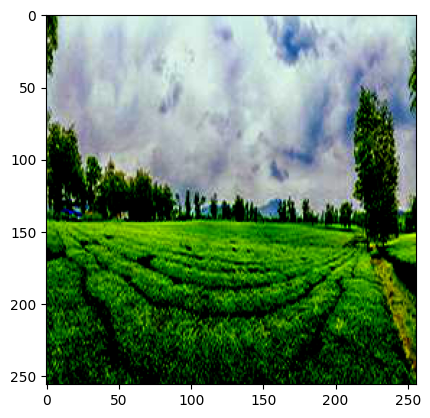

In [91]:
img = load_image(img_dir_path = IMAGE_PATH, X_path = '0a6e92d928.jpg')
plt.imshow(img.permute(1,2,0))

In [61]:
gen_Y = Generator(img_channels=3).to(DEVICE)
load_model(MODEL_PATH, gen_Y)

---> Loading Model


### Test Images

torch.Size([256, 512, 3])


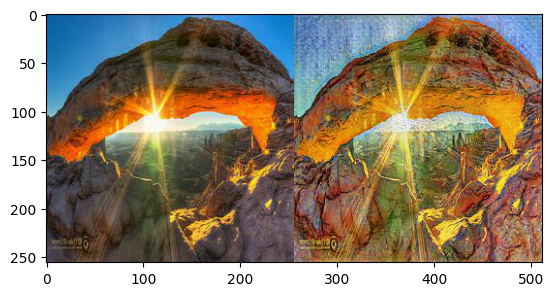

In [95]:
x_img = load_image(IMAGE_PATH, '0a49020ae5.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

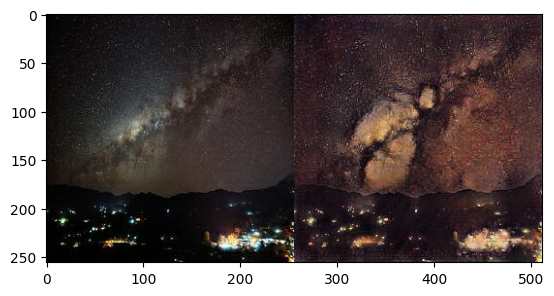

In [121]:
x_img = load_image(IMAGE_PATH, '0a2e5f728d.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

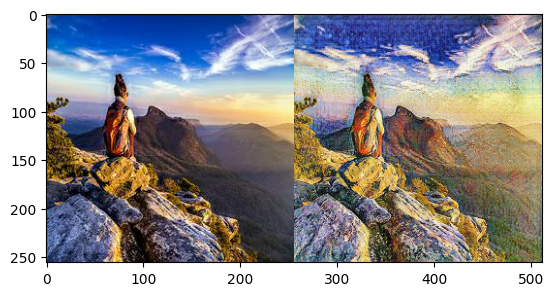

In [123]:
x_img = load_image(IMAGE_PATH, '0b68939003.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

### Camera Images

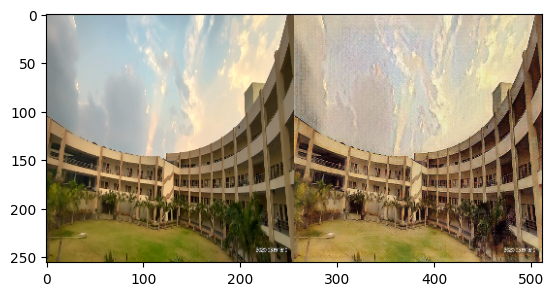

In [102]:
x_img = load_image(TEST_IMAGE_PATH, '1683807656343.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

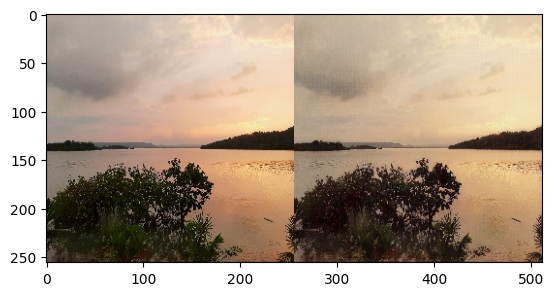

In [105]:
x_img = load_image(TEST_IMAGE_PATH, '1683807988581.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

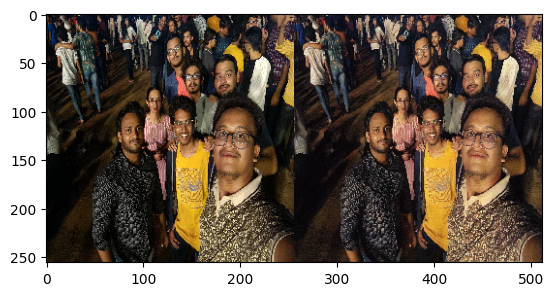

In [106]:
x_img = load_image(TEST_IMAGE_PATH, '1683808069053.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

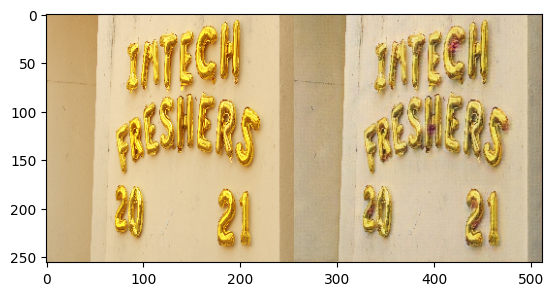

In [115]:
x_img = load_image(TEST_IMAGE_PATH, '1683807534115.JPG')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

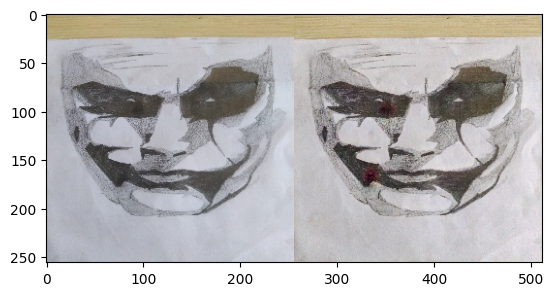

In [114]:
x_img = load_image(TEST_IMAGE_PATH, '1683807740168.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

### Monet Paintings

In [117]:
MONET_IMAGE = "/content/drive/MyDrive/Sem-8/DL/X_Monet/monet_jpg"

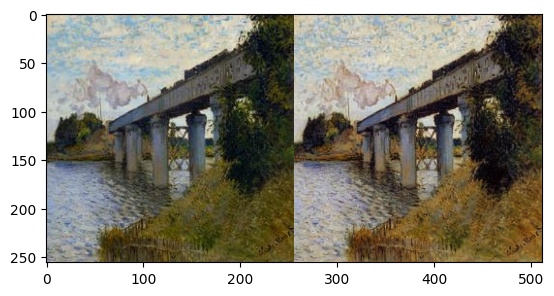

In [118]:
x_img = load_image(MONET_IMAGE, '1a127acf4d.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()

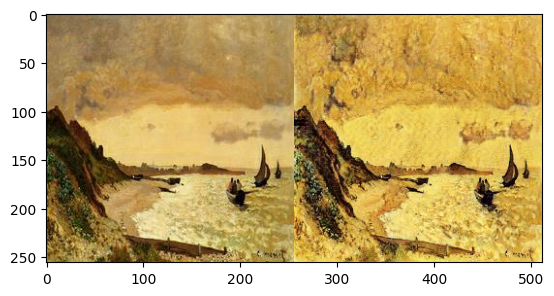

In [120]:
x_img = load_image(MONET_IMAGE, '8b54448a07.jpg')
y_img = gen_Y(x_img)

X_img = x_img * 0.5 + 0.5
Y_img = y_img * 0.5 + 0.5

with torch.no_grad():
  result = torch.hstack((X_img.permute(1,2,0), Y_img.permute(1,2,0)))
  plt.imshow(result)
  plt.show()